## Gruppe 3 (Alona, Jefferson) - Grammatical Error Correction für Deutsch ##

## 1. Einführung/ kurze Vorstellung 

### Was ist überhaupt T5? ###


T5: https://huggingface.co/docs/transformers/model_doc/t5#performance


____

Quelle:

Exploring Transfer Learning with T5: the Text-To-Text Transfer Transformer: https://ai.googleblog.com/2020/02/exploring-transfer-learning-with-t5.html

Exploring the Limits of Transfer Learning with a Unified Text-to-Text Transformer - Cornell University https://arxiv.org/abs/1910.10683

_______

## 2. Datenvorbereitung


Es gibt wenige frei-verfügbare Korpora in der Deutschen Sprache mit annotierten korrekten und fehlerhaften Sätzen. 

Unsere Korpora besteht insgesamt aus 10 500 annotierten Sätze-Paaren:

- 400 davon sind manuell-annotierte Beispiele, die von den Deutsch-lernenden (B1-B2) produziert wurden.
      
- 10 100 davon sind automatisch-annotierte Sätze aus der deutschen Nachrichten Korpora (2021). 
Quelle: https://wortschatz.uni-leipzig.de/de/download/German

D. Goldhahn, T. Eckart & U. Quasthoff: Building Large Monolingual Dictionaries at the Leipzig Corpora Collection: From 100 to 200 Languages In: Proceedings of the 8th International Language Resources and Evaluation,2012 

### Automatisch generierte Fehler

Für die automatische Annotierung haben wir die Sätze in 4 gleichen Teile aufgeteilt und folgende
Fehler automatisch eingeführt:

1. Das dritte Wort im Satz wurde "gescrambled".


In [ ]:
def scramble(sentence):
    words = sentence.split()
    if len(words) >=4:
        words[3] = ''.join(random.sample(words[3], len(words[3])))
    return ' '.join(words)

2. Alle "Der" und "die" Artikel wurden zu "das" und alle "en" und "es" Endungen wurden zu "e".


In [ ]:
def change(sentence):
    sentence = re.sub(r"\bDer\b", "Das", sentence)
    sentence = re.sub(r"\bder\b", "das", sentence)
    sentence = re.sub(r"en\b", "e", sentence)
    sentence = re.sub(r"es\b", "e", sentence)
    sentence = re.sub(r"\bdie\b", "das", sentence)
    return sentence

3. Das zweite Wort aus dem Satz wurde auf die vorletzte Stelle im Satz umgestellt.

In [ ]:
def move(sentence):
    words = sentence.split()
    if len(words) >=2:
        words.insert(-1, words.pop(1))
    return ' '.join(words)

4. Ein zufälliges Wort wurde aus dem Satz entfernt.

In [ ]:
def delete(sentence):
    words = sentence.split()
    if len(words)>=1:
        index = random.randint(0, len(words) -1)
        words.pop(index)
    return ' '.join(words)

Diese automatische Fehler haben zum Teil realistische und zum Teil nicht sehr realistische Fehler
produziert. Aber die Möglichkeit, die Daten automatisch vorzubereiten, hat uns erlaubt mehr als
10 000 Sätze für unseren Training zu benutzen. 

In dem CoNLL-2014 Shared Task on Grammatical Error Correction wurde NUS Corpus of Learner English benutzt, der von Essays besteht, die von Englisch-Lernenden verfasst wurden und von professionellen Englisch-Lehrern korrigiert. Sie haben insgesamt 57 151 Trainings-Sätze und 1312 Test-Sätze für den Task benutzt. Von der Qualität ist natürlich der NUS Corpus viel besser als unsere zum größten Teil automatisch-annotierte Korpora.

Quelle: Hwee Tou Ng, Siew Mei Wu, Ted Briscoe, Christian Hadiwinoto, Susanto, Raymond Hendy, Christopher Bryant: The CoNLL-2014 Shared Task on Grammatical Error Correction, 2014

_______

Bei dem CoNLL Shared Task wurden die Fehler in den Sätzen nicht nur korrigiert, sondern auch
mit Error-Typ versehen. In unseren Daten haben wir die Error-Typen nicht annotiert:


   
     input					                    target
    "grammar":Ob sie kennen gelernt er habe?	"corrections":Ob er sie kennen gelernt habe?


NUS Corpus enthält keine richtige Sätze. Unsere Daten enthalten auch 5% von Sätzen, die keine Korrektur benötigen. Diese korrekte Sätze haben aber keine große Auswirkung auf die Performanz gezeigt.

_____

Wie verschiedene Modelle im CoNLL 2014 Task abgeschnitten haben:

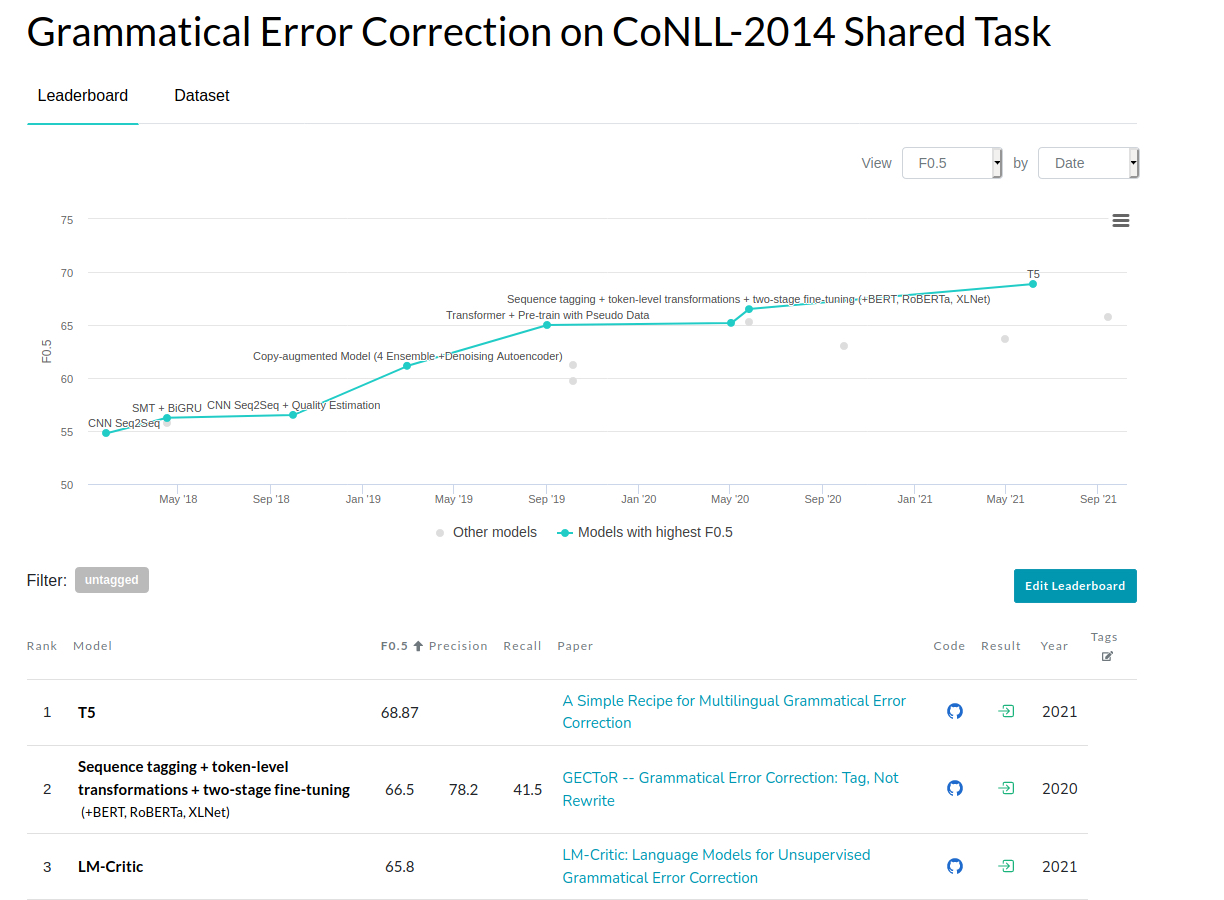

Quelle: https://paperswithcode.com/sota/grammatical-error-correction-on-conll-2014

_________

Wie man sieht, hat T5 Modell am besten in dem Task abgeschnitten. 

In dem Paper von Rothe, Sascha, et al. "A simple recipe for multilingual grammatical error correction." arXiv preprint arXiv:2106.03830 (2021). wird beschrieben, wie die Autoren den T5 Model gefinetuned haben, um die Fehlerkorrekturen in mehreren Sprachen machen zu können.

Die haben erstmal mit synthetischen Daten Vortraining gemacht. Dafür haben sie mc4 Corpus benutzt (multisprachiger webcrawler Corpus).  Sie haben die Daten selber tokeniziert und dann jeden Satz zerstört durch eine Kombination der folgenden Operationen: 

a) Auslassen von Tokens 

b) Vertauschen von Tokens 

c) Auslassen von Zeichen

d) Vertauschen von Zeichen

e) Einfügen von Zeichen 

f) Kleinschreibung eines Wortes 

g) Großschreibung des ersten Wortes


2% der Sätze in der Korpora waren richtig.

Danach haben sie das vortrainierte Modell mit den „natürlichen“ Daten gefinetuned, nämlich mit 
Lang-8 Corpus of Learner English. Das sind 237 843 Satzpaare. Diesen Korpus haben die Autoren verbessert, indem sie die Daten noch „gecleaned“ haben. (Duplikate entfernt, falsche Korrekturen, Ambiguitäten etc.)

Es wurden hier die Fehlertypen auch nicht separat annotiert. 

Wir haben diese Vorgehensweise übernommen, obwohl wir deutlich weniger Daten, sowohl synthetischen, wie auch die natürlichen, haben.
 
Wir haben auch zum Teil kompliziertere Fehler eingeführt in unseren automatischen Daten. In unserem Fall werden die Sätze auch strukturell „zerstört“, während Rothe et al.  eher die  Tokens „zerstören“.


# 3. Training

Wir haben insgesamt 3 Trainings und 9 Tests durchgeführt:

1) Training nur mit automatisch generierten Daten

2) Training mit manuell-annotierten Daten

3) Training mit einer 50/50 Mischung von automatisch generierten und manuell-annotierten Daten

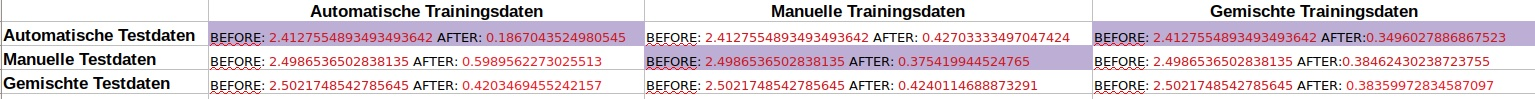

Die besten Ergebnisse erhält man, wenn man mit den automatisch generierten Daten trainiert und auf automatisch generierten Daten testet. 

Wenn man mit manuell-annotierten Daten trainiert und auf manuell-annotierten Daten testet, erhält man viel bessere Ergebnisse als wenn man mit synthetischen Daten oder gemischten Daten trainiert. 

Gemischte Trainingsdaten haben am besten bei den automatisch-annotierten Daten abgeschnitten.

### Trainingsdaten und Beispiele:

### 1. automatisch generierte Trainingsdaten, automatisch generierte Testdaten (insgesamt 10100 Sätze, gesplittet in 80% Trainingsdaten, 20% Testdaten) ###

--- Running evaluation ---

Num examples = 2022

Batch size = 1

**Before loss: 2.4127554893493493642**

____

--- Running training ---
  Num examples = 8085
  
  Num Epochs = 3
  
  Instantaneous batch size per device = 4
  
  Total train batch size (w. parallel, distributed & accumulation) = 4
  
  Gradient Accumulation steps = 1
  
  Total optimization steps = 6066
  
  Number of trainable parameters = 222903552
  
  8%|▊         | 500/6066 [25:49<4:41:46,  3.04s/it]{'loss': 0.4, 'learning_rate': 4.587866798549291e-05, 'epoch': 0.25}
  
 16%|█▋        | 1000/6066 [51:23<4:11:57,  2.98s/it]{'loss': 0.294, 'learning_rate': 4.175733597098582e-05, 'epoch': 0.49}
 
 25%|██▍       | 1500/6066 [1:24:41<5:10:24,  4.08s/it]{'loss': 0.2669, 'learning_rate': 3.763600395647874e-05, 'epoch': 0.74}
 
 33%|███▎      | 2000/6066 [2:07:39<4:52:09,  4.31s/it]{'loss': 0.2502, 'learning_rate': 3.3514671941971646e-05, 'epoch': 0.99}
 
 41%|████      | 2500/6066 [2:34:33<3:05:35,  3.12s/it]{'loss': 0.2057, 'learning_rate': 2.939333992746456e-05, 'epoch': 1.24}
 
  49%|████▉     | 3000/6066 [3:00:21<2:37:21,  3.08s/it]{'loss': 0.2035, 'learning_rate': 2.5272007912957468e-05, 'epoch': 1.48}
  
 58%|█████▊    | 3500/6066 [3:26:37<2:14:24,  3.14s/it]{'loss': 0.1976, 'learning_rate': 2.115067589845038e-05, 'epoch': 1.73}
 
 66%|██████▌   | 4000/6066 [3:52:44<1:52:59,  3.28s/it]{'loss': 0.1852, 'learning_rate': 1.702934388394329e-05, 'epoch': 1.98}
 
 74%|███████▍  | 4500/6066 [4:18:49<1:20:30,  3.08s/it]{'loss': 0.1737, 'learning_rate': 1.29080118694362e-05, 'epoch': 2.23}
 
 82%|████████▏ | 5000/6066 [4:44:37<57:24,  3.23s/it]{'loss': 0.1647, 'learning_rate': 8.786679854929115e-06, 'epoch': 2.47}
 
 91%|█████████ | 5500/6066 [5:11:45<32:17,  3.42s/it]{'loss': 0.158, 'learning_rate': 4.665347840422025e-06, 'epoch': 2.72}
 
 99%|█████████▉| 6000/6066 [5:38:09<03:24,  3.10s/it]{'loss': 0.1603, 'learning_rate': 5.440158259149357e-07, 'epoch': 2.97}
 
100%|██████████| 6066/6066 [5:41:27<00:00,  2.62s/it]
{'train_runtime': 20487.506, 'train_samples_per_second': 1.184, 'train_steps_per_second': 0.296, 'train_loss': 0.22107136481436337, 'epoch': 3.0}

--- Running Evaluation ---
  Num examples = 2022
  
  Batch size = 1
  
100%|██████████| 2022/2022 [04:56<00:00,  6.82it/s]


**After loss: 0.1867043524980545**

_________


**example_1 = "Wer hinterher und wer fällt fährt auf?"**

result_1 = happy_tt.generate_text(example_1, args=beam_settings)

print(result_1.text)

**Ergebnis: Wer fährt hinterher und wer fällt auf?**

### 2. automatisch generierte Trainingsdaten, manuelle Testdaten (8000 Sätze Trainingsdaten, 80 Sätze   Testdaten) ###

--- Running Evaluation ---

  Num examples = 80
  
  Batch size = 1

**Before loss: 2.4986536502838135**
___


--- Running Evaluation ---

  Num examples = 80
  
  Batch size = 1

**After loss : 0.5989562273025513**
___

**example_3 = "Warum hier er nicht steht, aber da?"**

result_3 = happy_tt.generate_text(example_3, args=beam_settings)

print(result_3.text)

**Ergebnis: Warum steht hier er nicht, aber da?**

### 3. automatisch generierte Trainingsdaten, gemischte Testdaten (81 automatisch generierte, 81 manuelle) ###

--- Running Evaluation ---

  Num examples = 161
  
  Batch size = 1
  

**After loss: 0.4203469455242157**

### 4. gemischte Trainingsdaten (319 automatisch generierte, 319 manuelle), gemischte Testdaten (81 automatisch generierte, 81 manuelle) ###

--- Running Evaluation ---

  Num examples = 161
  
  Batch size = 1

**Before loss: 2.5021748542785645**
___

--- Running training ---

  Num examples = 638
  
  Num Epochs = 3
  
  Instantaneous batch size per device = 4
  
  Total train batch size (w. parallel, distributed & accumulation) = 4
  
  Gradient Accumulation steps = 1
  
  Total optimization steps = 480
  
  Number of trainable parameters = 222903552
  
{'train_runtime': 1419.4326, 'train_samples_per_second': 1.348, 'train_steps_per_second': 0.338, 'train_loss': 0.4443244298299154, 'epoch': 3.0}


--- Running Evaluation ---

  Num examples = 161
  
  Batch size = 1

**example_2 = "Ich gehe zur Schule, weil ich will lernen."**

result_2 = happy_tt.generate_text(example_2, args=beam_settings)

print(result_2.text)

**Ergebnis: Ich gehe zur Schule, weil ich lernen werde.**

**After loss: 0.38359972834587097**



### 5.  manuelle Trainingsdaten (319 manuelle), manuelle Testdaten (81 manuelle) ###

--- Running Evaluation ---

  Num examples = 319
  
  Batch size = 1

**Before loss: 2.4986536502838135**
___

--- Running training ---

  Num examples = 319
  
  Num Epochs = 3
  
  Instantaneous batch size per device = 4
  
  Total train batch size (w. parallel, distributed & accumulation) = 4
  
  Gradient Accumulation steps = 1
  
  Total optimization steps = 240
  
  Number of trainable parameters = 222903552
  
100%|██████████| 240/240 [11:44<00:00,  2.79s/it]
{'train_runtime': 704.9726, 'train_samples_per_second': 1.357, 'train_steps_per_second': 0.34, 'train_loss': 0.5410540262858073, 'epoch': 3.0}

--- Running Evaluation ---

  Num examples = 80
  
  Batch size = 1
  
100%|██████████| 80/80 [00:09<00:00,  8.18it/s]


**After loss: 0.375419944524765**
